In [36]:
import pandas as pd
import numpy as np
import torch
import pandas
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from datasets import Dataset

In [37]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4080


In [38]:
df = pd.read_csv("cleaned_data.csv")
df

,title,url,text,dead,by,score,time,timestamp,type,id,parent_x,descendants,ranking,deleted,parent_y,content
0,Fetii (YC S22) Is Hiring,https://www.ycombinator.com/companies/fetii/jo...,NaN,NaN,Mattiommi,1.0,1747328407,2025-05-15 17:00:07+00:00,job,43996980,NaN,NaN,NaN,NaN,NaN,fetii yc s22 is hiring
1,Instant (YC S22) Is Hiring a Founding TypeScri...,https://www.instantdb.com/hiring/ts-hacker,NaN,NaN,stopachka,1.0,1746464426,2025-05-05 17:00:26+00:00,job,43897138,NaN,NaN,NaN,NaN,NaN,instant yc s22 is hiring a founding typescrip...
2,Tabular (YC S24) Is Hiring,https://www.ycombinator.com/companies/tabular/...,NaN,NaN,kilianjustus,1.0,1746601204,2025-05-07 07:00:04+00:00,job,43912944,NaN,NaN,NaN,NaN,NaN,tabular yc s24 is hiring
3,Ciro (YC S22) is hiring a software engineer to...,https://www.ycombinator.com/companies/ciro/jobs,NaN,NaN,dwiner,1.0,1746723638,2025-05-08 17:00:38+00:00,job,43928294,NaN,NaN,NaN,NaN,NaN,ciro yc s22 is hiring a software engineer to ...
4,Wondercraft (YC S22) Is Hiring,NaN,We are looking for a Senior Product Designer t...,NaN,youssefarizk,1.0,1743404419,2025-03-31 07:00:19+00:00,job,43532009,NaN,NaN,NaN,NaN,NaN,wondercraft yc s22 is hiring we are looking f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123092,"The movie mistake mystery from ""Revenge of the...",https://fxrant.blogspot.com/2025/04/the-movie-...,NaN,NaN,CharlesW,456.0,1745170168,2025-04-20 17:29:28+00:00,story,43745141,NaN,172.0,NaN,NaN,43745141.0,a bit late to the party but there is a famous ...
123093,Pentagon to terminate $5.1B in IT contracts wi...,https://www.reuters.com/world/us/pentagon-term...,NaN,NaN,oldprogrammer2,514.0,1744374193,2025-04-11 12:23:13+00:00,story,43653004,NaN,640.0,NaN,NaN,43653004.0,good government contractors usually overcharge...
123094,A hackable AI assistant using a single SQLite ...,https://www.geoffreylitt.com/2025/04/12/how-i-...,NaN,NaN,stevekrouse,800.0,1744638778,2025-04-14 13:52:58+00:00,story,43681287,NaN,174.0,NaN,NaN,43681287.0,love it such a nice idea coupled with a flawle...
123095,Show HN: Unsure Calculator – back-of-a-napkin ...,https://filiph.github.io/unsure/,NaN,NaN,filiph,930.0,1744705379,2025-04-15 08:22:59+00:00,story,43690289,NaN,162.0,NaN,NaN,43690289.0,awesome an alternative approach is using fuzzy...


In [39]:
def is_valid_content(text):
    if not isinstance(text, str):
        return False
    text = text.strip()
    word_count = len(text.split())

    if word_count < 10:
        return False
    if word_count > 1000000:
        return False

    lowered = text.lower()
    if any(kw in lowered for kw in ["is hiring", "show hn", "ask hn", "tell hn"]):
        return False
    return True

df_filtered = df[df["content"].apply(is_valid_content)]
print("Data after filtering：", len(df_filtered))

Data after filtering： 66581


In [40]:
df_filtered

,title,url,text,dead,by,score,time,timestamp,type,id,parent_x,descendants,ranking,deleted,parent_y,content
12,NaN,NaN,NaN,NaN,NaN,NaN,1739053859,2025-02-08 22:30:59+00:00,story,42986746,NaN,NaN,NaN,NaN,42986746.0,the app seems to just ask you an endless serie...
15,NaN,NaN,NaN,NaN,NaN,NaN,1747232791,2025-05-14 14:26:31+00:00,story,43984951,NaN,NaN,NaN,NaN,43984951.0,hi hn i asked this question on academia stacke...
35,NaN,NaN,NaN,NaN,NaN,NaN,1743787122,2025-04-04 17:18:42+00:00,story,43585317,NaN,NaN,NaN,NaN,43585317.0,i was working with a startup here in montreal ...
53,AI and the Mag 7. What will be the ROI on AI s...,https://mailchi.mp/verdadcap/ai-and-the-mag-7,NaN,NaN,Bostonian,1.0,1739201495,2025-02-10 15:31:35+00:00,story,43001433,NaN,0.0,NaN,NaN,43001433.0,ai and the mag 7 what will be the roi on ai s...
55,curl - gzip integer overflow - CVE-2025-0725,https://curl.se/docs/CVE-2025-0725.html,NaN,NaN,ChrisArchitect,1.0,1738773466,2025-02-05 16:37:46+00:00,story,42951046,NaN,1.0,NaN,NaN,42951046.0,related tbf cve 2025 0725 gzip integer overflo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123090,PEP 750 – Template Strings,https://peps.python.org/pep-0750/,NaN,NaN,grep_it,437.0,1744316641,2025-04-10 20:24:01+00:00,story,43647716,NaN,337.0,NaN,NaN,43647716.0,it s fascinating how differently languages app...
123092,"The movie mistake mystery from ""Revenge of the...",https://fxrant.blogspot.com/2025/04/the-movie-...,NaN,NaN,CharlesW,456.0,1745170168,2025-04-20 17:29:28+00:00,story,43745141,NaN,172.0,NaN,NaN,43745141.0,a bit late to the party but there is a famous ...
123093,Pentagon to terminate $5.1B in IT contracts wi...,https://www.reuters.com/world/us/pentagon-term...,NaN,NaN,oldprogrammer2,514.0,1744374193,2025-04-11 12:23:13+00:00,story,43653004,NaN,640.0,NaN,NaN,43653004.0,good government contractors usually overcharge...
123094,A hackable AI assistant using a single SQLite ...,https://www.geoffreylitt.com/2025/04/12/how-i-...,NaN,NaN,stevekrouse,800.0,1744638778,2025-04-14 13:52:58+00:00,story,43681287,NaN,174.0,NaN,NaN,43681287.0,love it such a nice idea coupled with a flawle...


In [41]:
# === Randomly sample 1000 for Zero-Shot classification test ===
df_sample = df_filtered.sample(n=10000, random_state=42)
df_sample.to_csv("sample_10000_for_zero_shot.csv", index=False)

In [42]:
BATCH_SIZE = 16
df = pd.read_csv("sample_10000_for_zero_shot.csv")
df

,title,url,text,dead,by,score,time,timestamp,type,id,parent_x,descendants,ranking,deleted,parent_y,content
0,Not Incentivized yet Efficient: Working from H...,https://papers.ssrn.com/sol3/papers.cfm?abstra...,NaN,NaN,MPLan,2.0,1740937326,2025-03-02 17:42:06+00:00,story,43232898,NaN,1.0,NaN,NaN,43232898.0,fenizia and kirchmaier 2025 fk studied the imp...
1,"Two Americas, one bank branch, and $50k cash",https://www.bitsaboutmoney.com/archive/two-ame...,NaN,NaN,dangrossman,78.0,1741198135,2025-03-05 18:08:55+00:00,story,43270103,NaN,66.0,NaN,NaN,43270103.0,coming from a fan of the blog newsletter and w...
2,"We achieve zero-downtime deployment (DB, back ...",https://ivelum.com/blog/zero-downtime-deployment/,NaN,NaN,stebunovd,1.0,1739893609,2025-02-18 15:46:49+00:00,story,43090853,NaN,0.0,NaN,NaN,NaN,we achieve zero downtime deployment db back e...
3,2 Planes Abort Landings as Army Helicopter Fli...,https://www.nytimes.com/2025/05/02/us/politics...,NaN,NaN,bookofjoe,40.0,1746529841,2025-05-06 11:10:41+00:00,story,43903771,NaN,17.0,NaN,NaN,43903771.0,commercial pilot and commentor indicates extre...
4,Netflix shares hit record as subscriber growth...,https://www.reuters.com/technology/netflix-sha...,NaN,NaN,testrun,3.0,1737552153,2025-01-22 13:22:33+00:00,story,42792508,NaN,0.0,NaN,NaN,42792508.0,netflix shares hit record as subscriber growt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Systemd ParticleOS,https://github.com/systemd/particleos,NaN,NaN,kblissett,89.0,1744329521,2025-04-10 23:58:41+00:00,story,43649088,NaN,68.0,NaN,NaN,43649088.0,i work in the embedded space i d absolutely lo...
9996,YouTubers Are Selling Their Unused Video Foota...,https://www.bloomberg.com/news/articles/2025-0...,NaN,NaN,phgn,4.0,1736552868,2025-01-10 23:47:48+00:00,story,42661742,NaN,0.0,NaN,NaN,NaN,youtubers are selling their unused video foot...
9997,BleepingComputer: Microsoft states creation of...,https://twitter.com/bleepincomputer/status/191...,NaN,NaN,Zarkex01,4.0,1744356604,2025-04-11 07:30:04+00:00,story,43651347,NaN,1.0,NaN,NaN,43651347.0,yes we totally meant to do that anyone who go...
9998,"Newscard: Decentralized, Anonymous Pastebin vi...",https://codeberg.org/OCTADE/newscard,NaN,NaN,OCTADE,2.0,1739183575,2025-02-10 10:32:55+00:00,story,42998873,NaN,1.0,NaN,NaN,42998873.0,newscard encrypts a local text file and publis...


In [43]:
candidate_labels = [
    "technology", "business", "entertainment", "science", "health",
    "education", "social issues", "politics", "psychology", "philosophy",
    "travel & lifestyle", "history", "economics", "AI/Machine Learning",
]


#   Model-distilbart-mnli-12-1

In [44]:
# Parameter setting
INPUT_CSV = "sample_10000_for_zero_shot.csv"
OUTPUT_CSV = "sample_10000_for_zero_shot.csv"
BATCH_SIZE = 32
MODEL_NAME = "valhalla/distilbart-mnli-12-1"

In [45]:
df = pd.read_csv(INPUT_CSV)
texts = df["content"].tolist()

In [46]:
# Load model (using GPU 0)

classifier = pipeline("zero-shot-classification",
                      model=MODEL_NAME,
                      device=0)

Device set to use cuda:0


In [47]:
tqdm.pandas()

In [48]:
results = []
for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Running Zero-Shot Inference (Top-1)"):
    batch = texts[i:i + BATCH_SIZE]
    output = classifier(batch, candidate_labels=candidate_labels, multi_label=True)
    results.extend(output)

Running Zero-Shot Inference (Top-1): 100%|██████████| 313/313 [20:18<00:00,  3.89s/it]


In [49]:
#Extract Top-1 label + score
top1_labels = [r["labels"][0] for r in results]
top1_scores = [r["scores"][0] for r in results]

In [50]:
df["predict"] = top1_labels
df["confidence"] = top1_scores

In [52]:
df.to_csv(OUTPUT_CSV, index=False)
df

,title,url,text,dead,by,score,time,timestamp,type,id,parent_x,descendants,ranking,deleted,parent_y,content,predict,confidence
0,Not Incentivized yet Efficient: Working from H...,https://papers.ssrn.com/sol3/papers.cfm?abstra...,NaN,NaN,MPLan,2.0,1740937326,2025-03-02 17:42:06+00:00,story,43232898,NaN,1.0,NaN,NaN,43232898.0,fenizia and kirchmaier 2025 fk studied the imp...,technology,0.551147
1,"Two Americas, one bank branch, and $50k cash",https://www.bitsaboutmoney.com/archive/two-ame...,NaN,NaN,dangrossman,78.0,1741198135,2025-03-05 18:08:55+00:00,story,43270103,NaN,66.0,NaN,NaN,43270103.0,coming from a fan of the blog newsletter and w...,travel & lifestyle,0.843752
2,"We achieve zero-downtime deployment (DB, back ...",https://ivelum.com/blog/zero-downtime-deployment/,NaN,NaN,stebunovd,1.0,1739893609,2025-02-18 15:46:49+00:00,story,43090853,NaN,0.0,NaN,NaN,NaN,we achieve zero downtime deployment db back e...,technology,0.982216
3,2 Planes Abort Landings as Army Helicopter Fli...,https://www.nytimes.com/2025/05/02/us/politics...,NaN,NaN,bookofjoe,40.0,1746529841,2025-05-06 11:10:41+00:00,story,43903771,NaN,17.0,NaN,NaN,43903771.0,commercial pilot and commentor indicates extre...,entertainment,0.963109
4,Netflix shares hit record as subscriber growth...,https://www.reuters.com/technology/netflix-sha...,NaN,NaN,testrun,3.0,1737552153,2025-01-22 13:22:33+00:00,story,42792508,NaN,0.0,NaN,NaN,42792508.0,netflix shares hit record as subscriber growt...,entertainment,0.976601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Systemd ParticleOS,https://github.com/systemd/particleos,NaN,NaN,kblissett,89.0,1744329521,2025-04-10 23:58:41+00:00,story,43649088,NaN,68.0,NaN,NaN,43649088.0,i work in the embedded space i d absolutely lo...,technology,0.812814
9996,YouTubers Are Selling Their Unused Video Foota...,https://www.bloomberg.com/news/articles/2025-0...,NaN,NaN,phgn,4.0,1736552868,2025-01-10 23:47:48+00:00,story,42661742,NaN,0.0,NaN,NaN,NaN,youtubers are selling their unused video foot...,business,0.959133
9997,BleepingComputer: Microsoft states creation of...,https://twitter.com/bleepincomputer/status/191...,NaN,NaN,Zarkex01,4.0,1744356604,2025-04-11 07:30:04+00:00,story,43651347,NaN,1.0,NaN,NaN,43651347.0,yes we totally meant to do that anyone who go...,technology,0.896417
9998,"Newscard: Decentralized, Anonymous Pastebin vi...",https://codeberg.org/OCTADE/newscard,NaN,NaN,OCTADE,2.0,1739183575,2025-02-10 10:32:55+00:00,story,42998873,NaN,1.0,NaN,NaN,42998873.0,newscard encrypts a local text file and publis...,technology,0.945435


## High confidence screening

In [53]:
df_result = pd.read_csv("sample_10000_for_zero_shot.csv")
high_conf_df = df_result[df_result["confidence"] >= 0.7].copy()
high_conf_df.to_csv("labeled data.csv", index=False)

## Bar chart of label distribution

C:\Users\seahi\AppData\Local\Temp\ipykernel_68120\903491629.py:9: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\seahi\AppData\Local\Temp\ipykernel_68120\903491629.py:9: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\seahi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\seahi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


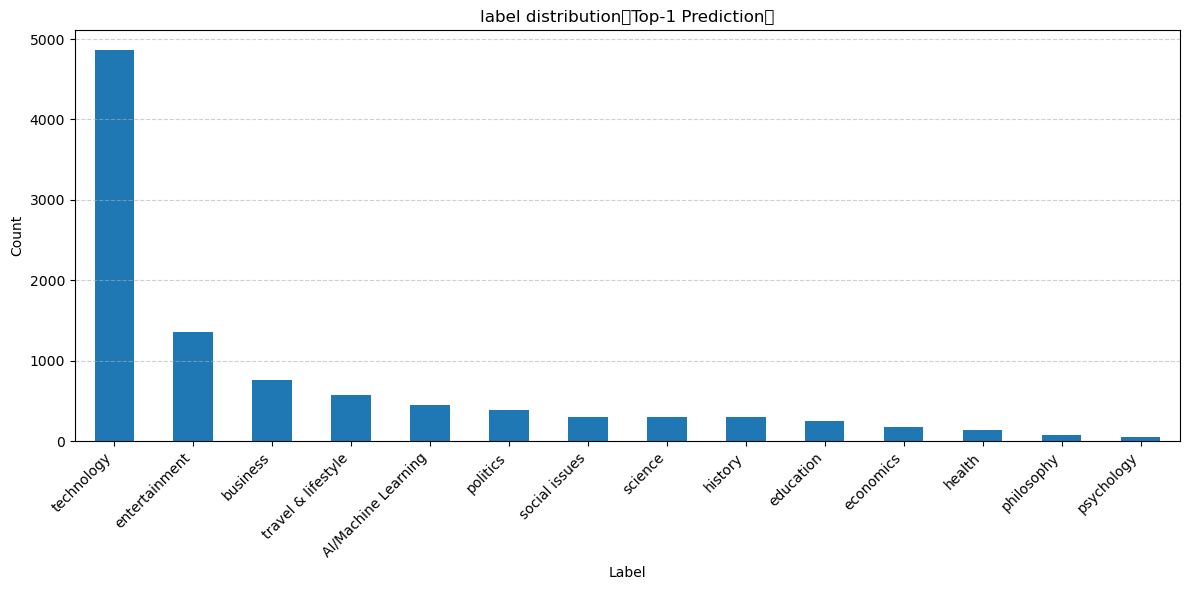

In [54]:
label_counts = df_result["predict"].value_counts()
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar")
plt.title("label distribution（Top-1 Prediction）")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Training script

In [56]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder

In [59]:
# Load dataset

df = pd.read_csv("labeled data.csv")
texts = df["content"].tolist()
labels = df["predict"].tolist()
df

,title,url,text,dead,by,score,time,timestamp,type,id,parent_x,descendants,ranking,deleted,parent_y,content,predict,confidence
0,"Two Americas, one bank branch, and $50k cash",https://www.bitsaboutmoney.com/archive/two-ame...,NaN,NaN,dangrossman,78.0,1741198135,2025-03-05 18:08:55+00:00,story,43270103,NaN,66.0,NaN,NaN,43270103.0,coming from a fan of the blog newsletter and w...,travel & lifestyle,0.843752
1,"We achieve zero-downtime deployment (DB, back ...",https://ivelum.com/blog/zero-downtime-deployment/,NaN,NaN,stebunovd,1.0,1739893609,2025-02-18 15:46:49+00:00,story,43090853,NaN,0.0,NaN,NaN,NaN,we achieve zero downtime deployment db back e...,technology,0.982216
2,2 Planes Abort Landings as Army Helicopter Fli...,https://www.nytimes.com/2025/05/02/us/politics...,NaN,NaN,bookofjoe,40.0,1746529841,2025-05-06 11:10:41+00:00,story,43903771,NaN,17.0,NaN,NaN,43903771.0,commercial pilot and commentor indicates extre...,entertainment,0.963109
3,Netflix shares hit record as subscriber growth...,https://www.reuters.com/technology/netflix-sha...,NaN,NaN,testrun,3.0,1737552153,2025-01-22 13:22:33+00:00,story,42792508,NaN,0.0,NaN,NaN,42792508.0,netflix shares hit record as subscriber growt...,entertainment,0.976601
4,"A woman made her AI voice clone say ""arse."" Th...",https://www.technologyreview.com/2025/02/14/11...,NaN,NaN,impish9208,56.0,1739541670,2025-02-14 14:01:10+00:00,story,43048345,NaN,64.0,NaN,NaN,43048345.0,i find it more disturbing that her private off...,technology,0.763576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6503,Systemd ParticleOS,https://github.com/systemd/particleos,NaN,NaN,kblissett,89.0,1744329521,2025-04-10 23:58:41+00:00,story,43649088,NaN,68.0,NaN,NaN,43649088.0,i work in the embedded space i d absolutely lo...,technology,0.812814
6504,YouTubers Are Selling Their Unused Video Foota...,https://www.bloomberg.com/news/articles/2025-0...,NaN,NaN,phgn,4.0,1736552868,2025-01-10 23:47:48+00:00,story,42661742,NaN,0.0,NaN,NaN,NaN,youtubers are selling their unused video foot...,business,0.959133
6505,BleepingComputer: Microsoft states creation of...,https://twitter.com/bleepincomputer/status/191...,NaN,NaN,Zarkex01,4.0,1744356604,2025-04-11 07:30:04+00:00,story,43651347,NaN,1.0,NaN,NaN,43651347.0,yes we totally meant to do that anyone who go...,technology,0.896417
6506,"Newscard: Decentralized, Anonymous Pastebin vi...",https://codeberg.org/OCTADE/newscard,NaN,NaN,OCTADE,2.0,1739183575,2025-02-10 10:32:55+00:00,story,42998873,NaN,1.0,NaN,NaN,42998873.0,newscard encrypts a local text file and publis...,technology,0.945435


In [62]:
# Label encoding

label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["predict"])
label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

In [63]:
# Convert to HF dataset

dataset = Dataset.from_pandas(df[["content", "label_id"]])
dataset = dataset.rename_column("label_id", "labels")
dataset = dataset.train_test_split(test_size=0.1)

In [64]:
# Tokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [65]:
def tokenize(example):
    return tokenizer(example["content"], truncation=True, padding="max_length", max_length=256)

encoded = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/5857 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

In [67]:
# Model initialization

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
# Training parameters

training_args = TrainingArguments(
    output_dir="./distilbert_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    logging_dir="./logs",
)

In [74]:
# Evaluation metrics
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [90]:
# Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\seahi\AppData\Local\Temp\ipykernel_68120\1439820011.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [76]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.127641,0.683564,0.688648
2,0.415500,1.211805,0.714286,0.698793
3,0.180600,1.328609,0.705069,0.697745


TrainOutput(global_step=1101, training_loss=0.280964513565604, metrics={'train_runtime': 78.1319, 'train_samples_per_second': 224.889, 'train_steps_per_second': 14.092, 'total_flos': 1164041385901056.0, 'train_loss': 0.280964513565604, 'epoch': 3.0})

In [77]:
#  Evaluate on test set
metrics = trainer.evaluate()
print("Evaluation on test set:")
print(metrics)

Evaluation on test set:
{'eval_loss': 1.1276413202285767, 'eval_accuracy': 0.6835637480798771, 'eval_f1': 0.6886475128626888, 'eval_runtime': 1.1532, 'eval_samples_per_second': 564.507, 'eval_steps_per_second': 35.553, 'epoch': 3.0}


In [78]:
# Save model and label mapping

trainer.save_model("distilbert_model")
tokenizer.save_pretrained("distilbert_model")
with open("distilbert_model/label2id.json", "w") as f:
    json.dump(label2id, f)


## bert-base-uncased

In [79]:
df = pd.read_csv("labeled data.csv")

In [80]:
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["predict"])
label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

In [81]:
dataset = Dataset.from_pandas(df[["content", "label_id"]])
dataset = dataset.rename_column("label_id", "labels")
dataset = dataset.train_test_split(test_size=0.1)

In [82]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\seahi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\seahi\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [83]:
def tokenize(example):
    return tokenizer(example["content"], truncation=True, padding="max_length", max_length=256)

encoded = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/5857 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

In [84]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [87]:
training_args = TrainingArguments(
    output_dir="./bert_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    logging_dir="./logs"
)

In [88]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\seahi\AppData\Local\Temp\ipykernel_68120\3368153831.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [89]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.019319,0.666667,0.638829
2,1.083900,0.941003,0.709677,0.691614
3,0.516100,1.010656,0.698925,0.683083


TrainOutput(global_step=1101, training_loss=0.7604701763710902, metrics={'train_runtime': 152.3213, 'train_samples_per_second': 115.355, 'train_steps_per_second': 7.228, 'total_flos': 2311811231874048.0, 'train_loss': 0.7604701763710902, 'epoch': 3.0})

In [91]:
metrics = trainer.evaluate()
print("Evaluation on test set:")
print(metrics)

📊 Evaluation on test set:
{'eval_loss': 0.9410030841827393, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.7096774193548387, 'eval_f1': 0.6916135370419108, 'eval_runtime': 1.9013, 'eval_samples_per_second': 342.389, 'eval_steps_per_second': 21.564}


In [92]:
trainer.save_model("bert_model")
tokenizer.save_pretrained("bert_model")
with open("bert_model/label2id.json", "w") as f:
    json.dump(label2id, f)